# Livrable 1 - Classification binaire

In [487]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import os
from kerastuner.tuners import RandomSearch
from kerastuner import HyperParameters
hp = HyperParameters()
import time
from tensorflow.keras.callbacks import TensorBoard


## Chemin du DataSet

In [479]:
# Chemin vers le dataset
data_dir = r"..\..\..\DataSets\clean_dataset"

In [480]:
# Fonction pour compter le nombre d'images dans un dossier
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

painting_path = os.path.join(data_dir, 'image', 'Painting')
schematics_path = os.path.join(data_dir, 'image', 'Schematics')
sketch_path = os.path.join(data_dir, 'image', 'Sketch')
text_path = os.path.join(data_dir, 'image', 'text')
photo_path = os.path.join(data_dir, 'Photo')

num_paintings = count_images_in_folder(painting_path)
num_schematics = count_images_in_folder(schematics_path)
num_sketches = count_images_in_folder(sketch_path)
num_text = count_images_in_folder(text_path)
num_photos = count_images_in_folder(photo_path)

print(f"Paintings: {num_paintings}, Schematics: {num_schematics}, Sketches: {num_sketches}, Text: {num_text}, Photos: {num_photos}")


Paintings: 794, Schematics: 4261, Sketches: 613, Text: 4329, Photos: 9997


In [481]:
# Paramètres de base
input_shape = (128, 128, 3)  # Format d'image
batch_size = 32
epochs = 10

## Rescale (normalisation)

Le paramètre rescale=1./255 normalise les valeurs des pixels de l'image en les divisant par 255. Cela signifie que les valeurs des pixels, qui sont normalement dans la plage de 0 à 255 (puisque les images sont généralement encodées en 8 bits), sont mises à l'échelle pour être comprises entre 0 et 1.

et aussi un réechantillonage en focntion des poids des classe

In [482]:
# Normalisation des valeurs des pixels de l'image de [0, 255] à [0, 1] pour faciliter l'entraînement du modèle
normalization_layer = tf.keras.layers.Rescaling(1./255)


## Split des données


Dans notre cas, le déséquilibre entre "Image" et "Photo" est modéré (ce que semble indiquer nos poids de classe), nous allons commencer avec l'utilisation des poids de classe. C'est une solution simple et efficace dans la plupart des cas, surtout si l'écart entre les classes n'est pas trop important.

Sinon après analyse des performances, si nous constatons que la classe minoritaire n'est toujours pas bien apprise, nous pouvez alors envisager d'ajouter un rééchantillonnage pour cette classe en appliquant des techniques de data augmentation sur les images de la classe "Image".
redimensionnement et orientation différente de s image (ex 18 degres, ect.. workshop 2)


In [483]:
# Charger le jeu de données d'entraînement
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% d'entraînement, 20% de validation
    subset="training",  # Sous-ensemble d'entraînement
    seed=42,  # Pour reproduire les résultats
    image_size=(128, 128),  # Taille des images redimensionnées
    batch_size=batch_size  # Taille des batchs
)

# Charger le jeu de données de validation
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% d'entraînement, 20% de validation
    subset="validation",  # Sous-ensemble de validation
    seed=42,  # Pour reproduire les résultats
    image_size=(128, 128),  # Taille des images redimensionnées
    batch_size=batch_size  # Taille des batchs
)


Found 19994 files belonging to 2 classes.
Using 15996 files for training.
Found 19994 files belonging to 2 classes.
Using 3998 files for validation.


### 1ère Etape- Création du modèle CNN : EfficientNet

In [484]:
# Fonction de construction du modèle pour le tuner
def build_model(hp):
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    
    # Dégeler les 20 dernières couches d'EfficientNet
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model = Sequential()

# Ajout du modèle de base pré-entraîné (EfficientNetB0 dans ce cas) pour l'extraction de caractéristiques
    model.add(base_model)

# Ajout d'une couche de Pooling Global Moyenne pour réduire les dimensions tout en conservant les caractéristiques les plus importantes
    model.add(GlobalAveragePooling2D())

# Ajout d'une couche Dense complètement connectée, avec un nombre d'unités sélectionné via Keras Tuner
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))

# Ajout d'une couche de normalisation pour stabiliser et accélérer l'entraînement du modèle
    model.add(BatchNormalization())

# Ajout d'une couche de Dropout pour réduire le surapprentissage, avec un taux défini par Keras Tuner
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)))

# Ajout de la couche de sortie, avec une unité de sortie et une activation sigmoïde pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))


    # Compilation du modèle
    model.compile(
    # Utilisation de l'optimiseur Adam, avec le taux d'apprentissage sélectionné via Keras Tuner parmi plusieurs valeurs possibles
    optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    
    # Utilisation de la fonction de perte 'binary_crossentropy' pour les problèmes de classification binaire
    loss='binary_crossentropy',
    
    # Suivi de l'exactitude (accuracy) comme métrique pour évaluer les performances du modèle
    metrics=['accuracy']
)

    
    return model


### 2ème Etape - Utilisation du RandomSearch

In [465]:
 # Utilisation de Keras Tuner pour trouver les meilleurs hyperparamètres
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='efficientnet_tuning'
)

Reloading Tuner from tuner_results\efficientnet_tuning\tuner0.json


In [466]:
def plot_training(history, trial_num):
    # Définir la taille de la figure pour les graphiques de l'historique d'entraînement
    plt.figure(figsize=(12, 5))

    # Créer le premier sous-graphe pour la précision (accuracy) d'entraînement et de validation
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Précision pendant l'entraînement
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Précision pendant la validation
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Trial {trial_num} - Accuracy')  # Titre indiquant le numéro de l'essai

    # Créer le deuxième sous-graphe pour la perte (loss) d'entraînement et de validation
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')  # Perte pendant l'entraînement
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Perte pendant la validation
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Trial {trial_num} - Loss')  # Titre indiquant le numéro de l'essai

    # Ajuster l'espacement entre les sous-graphiques pour une meilleure présentation
    plt.tight_layout()
    
    # Afficher les graphiques
    plt.show()


In [467]:
def custom_search(tuner, train_set, test_set, epochs):
    # Boucle pour exécuter chaque essai de recherche d'hyperparamètres jusqu'à atteindre le nombre maximal d'essais
    for trial_num in range(tuner.oracle.max_trials):
        
        # Mettre à jour les informations sur l'essai en cours dans l'oracle du tuner
        tuner.oracle.update_trial(trial_num)
        
        # Construire un modèle basé sur les hyperparamètres de l'essai actuel
        model = tuner.hypermodel.build(tuner.oracle.get_trial(trial_num).hyperparameters)
        
        # Entraîner le modèle sur le jeu d'entraînement, avec validation sur le jeu de test
        history = model.fit(
            train_set,
            epochs=epochs,
            validation_data=test_set,
            callbacks=[
                # Arrêt précoce pour arrêter l'entraînement lorsque la validation n'améliore plus pendant un certain nombre d'époques
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
                
                # Réduction du taux d'apprentissage lorsque la perte de validation stagne, pour affiner davantage le modèle
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
            ]
        )
        
        # Tracer les courbes d'entraînement et de validation pour cet essai
        plot_training(history, trial_num + 1)


In [468]:
# Exécuter la recherche des meilleurs hyperparamètres sur le jeu d'entraînement
tuner.search(
    train_set,
    epochs=10,  # Entraîner pendant 10 époques au maximum
    validation_data=test_set,  # Utiliser le jeu de test pour la validation
    callbacks=[
        # Arrêt précoce si la perte de validation n'améliore plus pendant 3 époques, pour éviter le surentraînement
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ]
)

# Exécuter la recherche personnalisée et afficher les graphiques
custom_search(tuner, train_set, test_set, epochs)

# Récupérer le meilleur modèle
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Entraînement du modèle avec les meilleurs hyperparamètres
history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=test_set,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    ]
)

# Visualisation des résultats/Performance du modèle final
plot_training(history, 'Best Model')
def measure_execution_time():
    start_time = time.time()
    yield
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")




Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
384               |512               |dense_units
0.4               |0.5               |dropout
0.0001            |0.0001            |learning_rate

Epoch 1/10


KeyboardInterrupt: 

## 3ème Etape - Utilisation des Hyperparamètres

In [469]:
learning_rate = 0.0001  # Meilleur taux d'apprentissage trouvé

In [470]:
# Construction du modèle EfficientNetB0
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)


In [471]:
# Dégeler les 20 dernières couches d'EfficientNet
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True


In [472]:
model = Sequential()

# Ajout du modèle de base pré-entraîné (par exemple, EfficientNetB0) pour l'extraction de caractéristiques
model.add(base_model)

# Ajout d'une couche de Pooling Global Moyenne pour réduire la dimensionnalité tout en conservant les caractéristiques importantes
model.add(GlobalAveragePooling2D())

# Ajout d'une couche Dense complètement connectée avec 512 unités et une activation ReLU
model.add(Dense(512, activation='relu'))

# Ajout d'une couche de normalisation pour stabiliser et accélérer l'entraînement du modèle
model.add(BatchNormalization())

# Ajout d'une couche de Dropout avec un taux de 50 % pour réduire le surapprentissage
model.add(Dropout(0.5))

# Ajout de la couche de sortie avec une activation sigmoïde pour la classification binaire
model.add(Dense(1, activation='sigmoid'))


In [473]:
# Compilation du modèle
model.compile(
    # Utilisation de l'optimiseur Adam avec un taux d'apprentissage de 0.0001
    optimizer=Adam(learning_rate=0.0001),
    
    # Utilisation de la fonction de perte 'binary_crossentropy' pour un problème de classification binaire
    loss='binary_crossentropy',
    
    # Suivi de la métrique 'accuracy' pour évaluer la performance du modèle pendant l'entraînement
    metrics=['accuracy']
)


In [474]:
# Afficher un résumé du modèle, y compris la structure des couches, le nombre de paramètres, et la forme des sorties
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,708,004 (17.96 MB)

 Trainable params: 2,008,369 (7.66 MB)

 Non-trainable params: 2,699,635 (10.30 MB)

In [477]:
# Entraînement du modèle avec callbacks
history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=test_set,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    ]
)


 89/500 ━━━━━━━━━━━━━━━━━━━━ 2:24 352ms/step - accuracy: 0.8473 - loss: 0.3936

KeyboardInterrupt: 

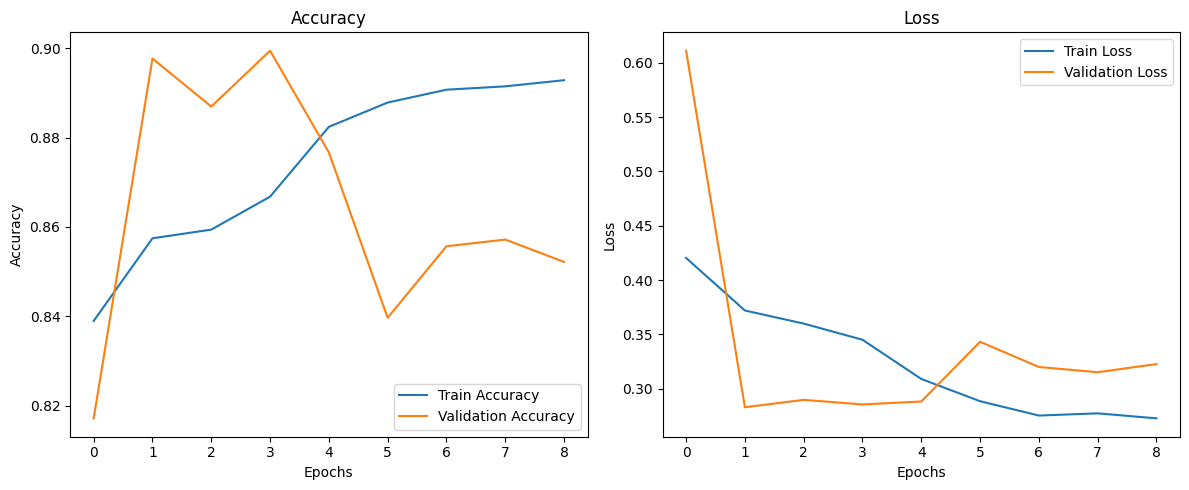

In [452]:
# Visualisation des résultats/Performance du modèle
def plot_training(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

plot_training(history)

## TensorBoard pour visualiser l'entraînement

In [488]:
log_dir = os.path.join("logs", "classification")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## Sauvegarde des poids

In [489]:
model.save_weights('model.random10.weights.h5')

In [490]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fonction de prédiction avec probabilités
def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128))  # Adapter la taille à celle du modèle
    img_array = img_to_array(img)  # Conversion en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    img_array /= 255.0  # Normalisation de l'image

    # Prédiction binaire (probabilité unique)
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  # Probabilité que l'image soit une "Photo"
    
    # Classification basée sur la probabilité
    if probability > 0.7:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Not-Photo'  # "Image" comme Not-Photo dans ce cas

    # Retourner la classe prédite et les probabilités (classe photo et non-photo)
    return predicted_class, [probability, 1 - probability]

# Fonction d'affichage des images avec probabilités
def display_images_with_binary_probabilities(model_save, dataset_dir, num_images=6):
    subfolders = ['Painting', 'Schematics', 'Sketch', 'Text']  # Liste des sous-dossiers d'images
    folder = ["Image","photo"]
    fig, axes = plt.subplots(2, num_images//2, figsize=(18, 8))  # Créer une grille pour afficher les images

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']  # Extensions d'images valides

    for i in range(num_images):
        randomfolder = random.choice(folder) 
        if randomfolder == "photo":
             image_folder = os.path.join(dataset_dir, randomfolder) 
        else:
            subfolder = random.choice(subfolders)
            image_folder = os.path.join(dataset_dir, randomfolder, subfolder)  

        # Vérifier l'existence du sous-dossier
        if not os.path.exists(image_folder):
            print(f"Folder not found: {image_folder}")
            continue
        
        try:
            # Fichiers valides dans le sous-dossier
            valid_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_extensions]
            
            if len(valid_files) == 0:
                print(f"No valid image files found in: {image_folder}")
                continue

            random_image = random.choice(valid_files)
            image_path = os.path.join(image_folder, random_image)

            # Charger l'image et obtenir la prédiction
            img = load_img(image_path, target_size=(256, 256))  # Pour une meilleure visibilité
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Sélectionner l'emplacement dans la grille (axes)
            ax = axes[i // (num_images // 2), i % (num_images // 2)]
            ax.imshow(img)
            ax.axis('off')

            # Afficher la classe prédite et le pourcentage
            probability_photo = probabilities[0] * 100  # Probabilité que ce soit une "Photo"
            ax.set_title(f'Predicted Class: {predicted_class} ({probability_photo:.2f}%)', fontsize=12)

        except Exception as e:
            print(f"An error occurred: {e}")
            ax.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            continue

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
An error occurred: index 2 is out of bounds for axis 0 with size 2


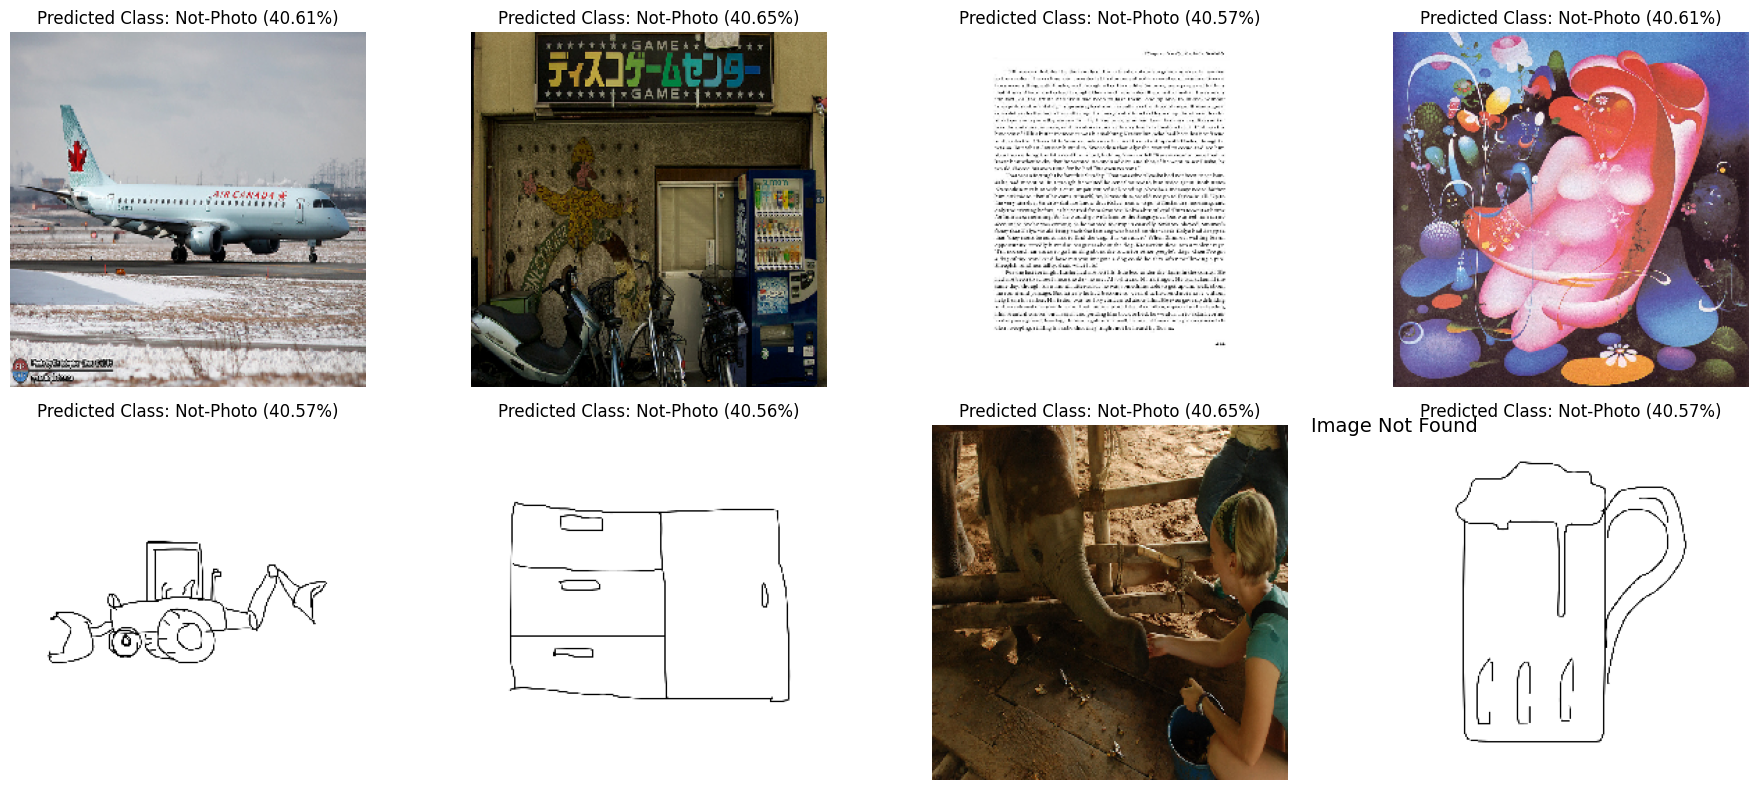

In [491]:
# Afficher des images avec leurs probabilités prédictives binaires, pour visualiser la performance du modèle sur des échantillons
display_images_with_binary_probabilities(model, dataset_dir, num_images=9)

# Utilisation des Poids Sauvegarder


In [492]:
# Créer un modèle séquentiel vide qui sera utilisé pour sauvegarder les poids après l'entraînement
model_save_weights = Sequential()

In [493]:
odel_save_weights = Sequential()

model_save_weights.add(base_model)
model_save_weights.add(GlobalAveragePooling2D())
model_save_weights.add(Dense(512, activation='relu'))
model_save_weights.add(BatchNormalization())
model_save_weights.add(Dropout(0.5))
model_save_weights.add(Dense(1, activation='sigmoid'))

In [494]:
model_save_weights.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [496]:
model_save_weights.load_weights('model.random10.weights.h5')

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


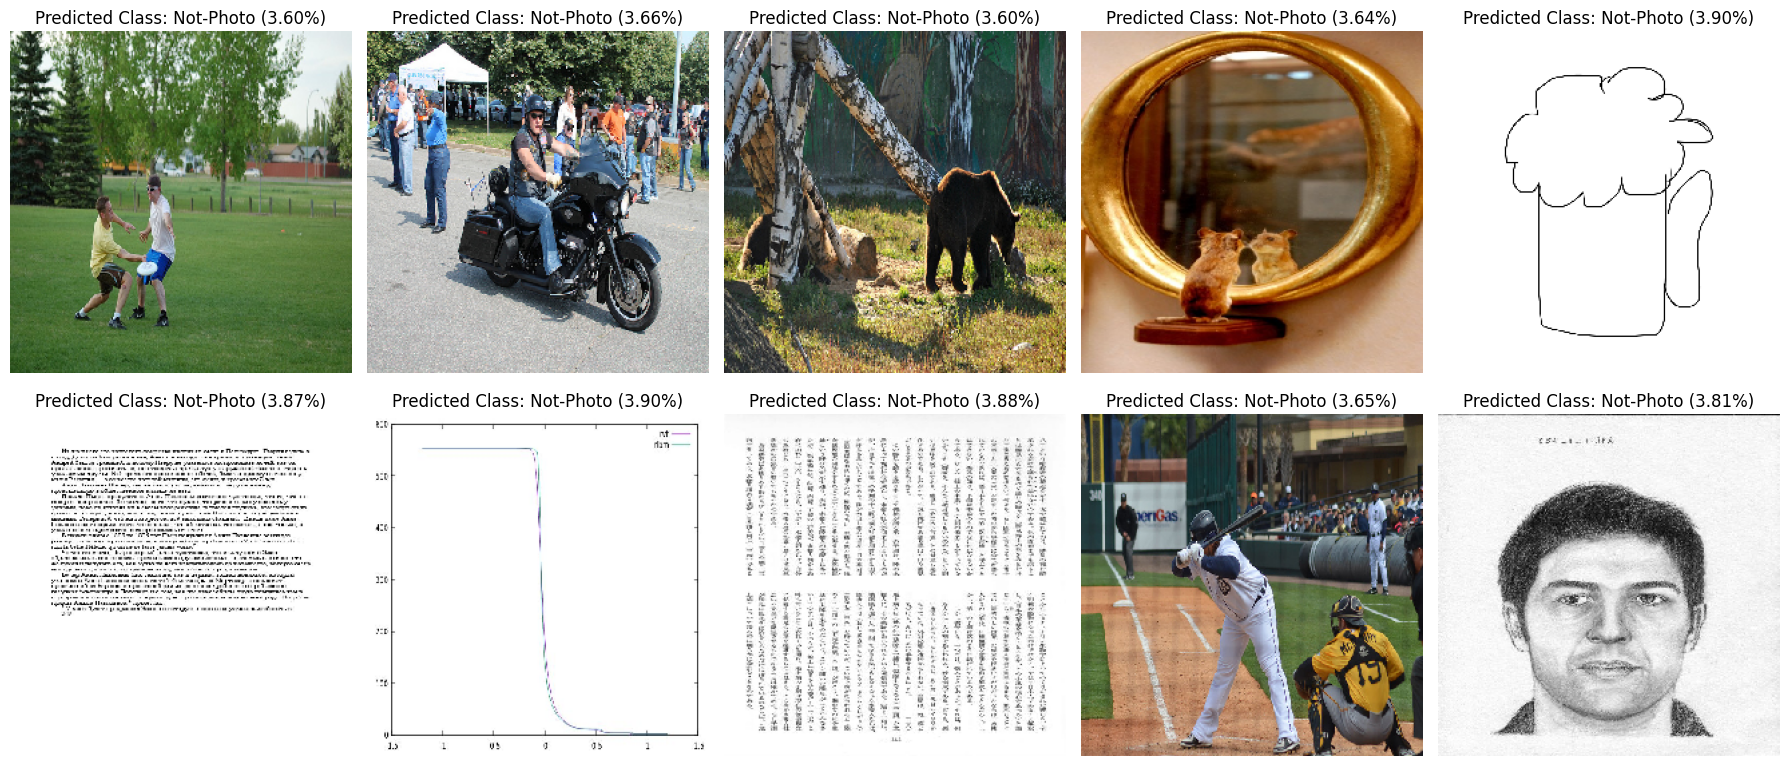

In [497]:
display_images_with_binary_probabilities(model_save_weights, dataset_dir, num_images=10)